In [1]:
%pylab inline

import os
import sys
import numpy as np
from skimage import measure

import importlib

import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as plticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [1]:
current_path = !pwd
parent_path = os.path.dirname(current_path[0])
if parent_path not in sys.path: sys.path.append(parent_path)
work_path = "/".join(parent_path.split('/')[:-1])
if work_path not in sys.path: sys.path.append(work_path)
#santi_path = work_path+"/santi-iso-response"
#if santi_path not in sys.path: sys.path.append(santi_path)
#santi_etc_path = os.path.join(santi_path, 'etc')
#sys.path.append(santi_etc_path)

from santi-iso-response.models.cnn_sys_ident.data import Dataset, MonkeyDataset
from santi-iso-response.models.cnn_sys_ident.cnn import ConvNet
from santi-iso-response.iso_response.utils import load_model, get_activations, get_activations_cell

SyntaxError: invalid syntax (<ipython-input-1-44b699fec9ee>, line 11)

In [3]:
from iso_response.utils import load_model, get_activations, get_activations_cell

In [4]:
text_width = 416.83269 #pt = 14.65cm
fontsize = 12
dpi = 800
font_settings = {
        "text.usetex": True,
        "font.family": "serif",
        "axes.labelsize": fontsize,
        "axes.titlesize": fontsize,
        "figure.titlesize": fontsize,
        "font.size": fontsize,
        "legend.fontsize": fontsize,
        "xtick.labelsize": fontsize-2,
        "ytick.labelsize": fontsize-2,
}
mpl.rcParams.update(font_settings)
#os.environ["PATH"] += os.pathsep + '/gpfs01/bethge/home/dpaiton/bin/latex'
plt.rc('text', usetex=True)

color_vals = dict(zip(["blk", "lt_green", "md_green", "dk_green", "lt_blue", "md_blue", "dk_blue", "lt_red", "md_red", "dk_red"],
  ["#000000", "#A9DFBF", "#196F3D", "#27AE60", "#AED6F1", "#3498DB", "#21618C", "#F5B7B1", "#E74C3C", "#943126"]))

### Load Model

In [5]:
model = load_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /gpfs01/bethge/home/dpaiton/Work/iso-response/models/train_logs/cnn-weights/7fdb18e061/best.ckpt


Get a few images from a training set:

In [6]:
images,_,_ = model.data.train()

Get the activations for the first 10 images for all 166 neurons

In [7]:
activations = get_activations(model, images[:10])
print(activations.shape)

(10, 166)


Get the activations for only one cell (eg. cell 26) for the first 10 images

In [8]:
activations = get_activations_cell(model, images[:10], 26)
print(activations.shape)

(10,)


### Load MEIs

In [9]:
with open(os.path.join(etc_path, 'meis.pkl'), 'rb') as g:
    meis = pickle.load(g)

In [10]:
images, activations, performance = meis['images'], meis['activations'], meis['performance']

#### visualize meis

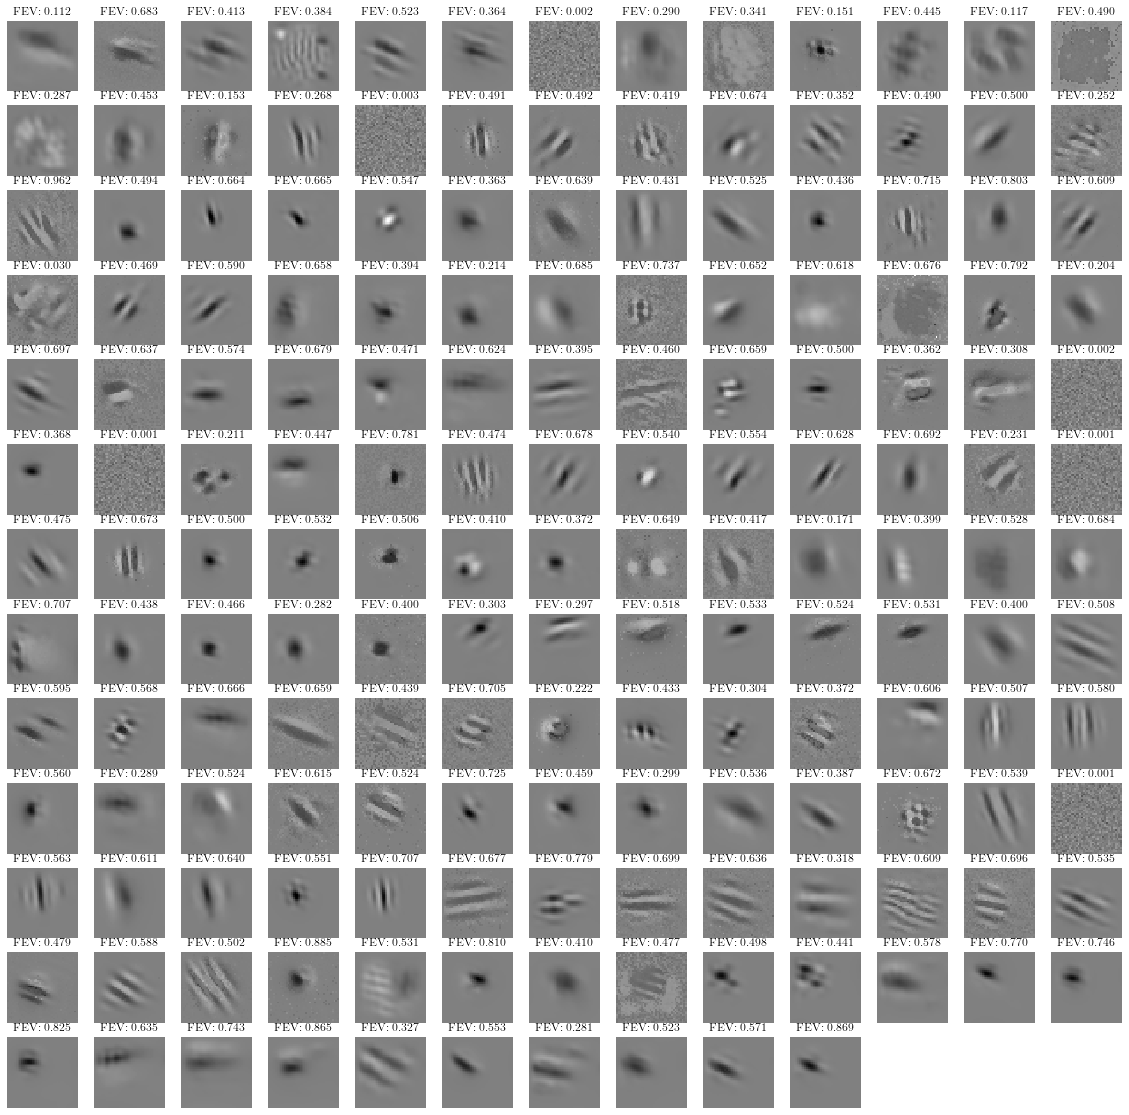

In [11]:
num_neurons = len(images)
fig, axes = plt.subplots(13,13, figsize=(20,20))
vmin = -3
vmax = 3

for ind, ax in enumerate(axes.flatten()):
    if ind < num_neurons:
        ax.imshow(images[ind], cmap = 'gray', vmin = vmin, vmax= vmax)
        ax.set_title('FEV: {:.3f}'.format(performance[ind])) # set as title the fraction of explainable variance explained
    ax.axis('off')
    

Get the activations from the MEI of neuron 43

In [12]:
get_activations_cell(model, meis['images'][43][np.newaxis,:,:], 43)

array([3.359448], dtype=float32)

In [13]:
meis['activations'][43]

3.359448

In [14]:
meis['performance'][43] # explainable variance explained for neuron 43

0.394098

In [15]:
len(meis["images"])

166

### Iso-response analysis

In [27]:
def gram_schmidt(target_vector, comp_vector):
    """
    Perform a single step of the Gram-Schmidt process 
    https://en.wikipedia.org/wiki/Gram-Schmidt_process
    Inputs:
        target_vector [np.ndarray] of shape [num_pixels,]
        comp_vector [np.ndarray] of shape [num_pixels,]
    Outputs:
        orth_norm [np.ndarray] of shape [num_pixels,] that is orthogonal to target_vector and has unit norm
    """
    t_norm = np.squeeze((target_vector / np.linalg.norm(target_vector)).T)
    c_norm = np.squeeze((comp_vector / np.linalg.norm(comp_vector)).T)
    orth_vector = c_norm - np.dot(c_norm[:,None].T, t_norm[:,None]) * t_norm
    orth_norm = np.squeeze((orth_vector / np.linalg.norm(orth_vector)).T)
    return orth_norm

def get_proj_matrix(target_vector, comp_vector, comp_is_orth=False):
    """
    Find a projection basis that is orthogonal to target_vector 
    Uses a single step of the Gram-Schmidt process
    Inputs:
        target_vector [np.ndarray] of shape [num_pixels,]
        comp_vector [np.ndarray] of shape [num_pixels,]
        comp_is_orth [bool] If false, find orth vector that is as close as possible to comp_vector
    Outputs:
        projection_matrix [tuple] containing [ax_1, ax_2] for projecting data into the 2d array
    """
    if comp_is_orth:
        orth_vector = comp_vector
    else:
        orth_vector = gram_schmidt(target_vector, comp_vector)
    proj_matrix = np.stack([target_vector, orth_vector], axis=0)
    return proj_matrix

def find_orth_vect(matrix):
    """
    Given an orthonormal matrix, find a new unit vector that is orthogonal
    Inputs:
        matrix [np.ndarray] matrix whose columns are each orthonormal vectors
    Outputs:
        orth_vect [np.ndarray] unit vector that is orthogonal to all of the vectors in the input matrix
    """
    rand_vect = np.random.rand(matrix.shape[0], 1)
    new_matrix = np.hstack((matrix, rand_vect))
    candidate_vect = np.zeros(matrix.shape[1]+1)
    candidate_vect[-1] = 1
    orth_vect = np.linalg.lstsq(new_matrix.T, candidate_vect, rcond=None)[0] # [0] indexes lst-sqrs solution
    orth_vect = np.squeeze((orth_vect / np.linalg.norm(orth_vect)).T)
    return orth_vect

def get_rand_orth_vectors(target_vector, num_orth_directions):
    """
    Given a vector, construct a matrix of shape [num_orth_directions, vector_length] of vectors
    that are orthogonal to the input
    Inputs:
      target_vector [np.ndarray] initial vector
      num_orth_directions [int] number of orthogonal vectors to construct
    Outputs:
      rand_vectors [np.ndarray] output matrix of shape [num_orth_directions, vector_length] containing vectors
      that are all orthogonal to target_vector
    """
    rand_vectors = target_vector.T[:,None] # matrix of alternate vectors
    for orth_idx in range(num_orth_directions):
        tmp_vect = find_orth_vect(rand_vectors)
        rand_vectors = np.append(rand_vectors, tmp_vect[:,None], axis=1)
    return rand_vectors.T[1:, :]

def get_image_angles(images):
    """
    Compute the angle in degrees between all pairs of basis functions in bf_stats
    Outputs:
        image_angles [np.ndarray] lower triangle of plot matrix only, as a vector in raster order
        plot_matrix [np.ndarray] of shape [num_images, num_images] with all angles between
            basis functions in the lower triangle and upper triangle is set to -1
    Inputs:
        images [list] list of images to compute the angle bewteen
    """
    num_images = len(images)
    num_pixels = images[0].size
    indices = np.tril_indices(num_images, 1)
    vect_size = len(indices[0])
    image_angles = np.zeros(vect_size)
    plot_matrix = np.zeros((num_images, num_images))
    for angleid, (nid0, nid1) in enumerate(zip(*indices)):
        im0 = images[nid0].reshape((num_pixels, 1))
        im1 = images[nid1].reshape((num_pixels, 1))
        inner_products = np.dot((im0 / np.linalg.norm(im0)).T, (im1 / np.linalg.norm(im1)))
        inner_products[inner_products>1.0] = 1.0
        inner_products[inner_products<-1.0] = -1.0
        angle = np.arccos(inner_products)
        image_angles[angleid] = angle * (180 / np.pi)
        plot_matrix[nid0, nid1] = angle * (180 / np.pi)
    plot_matrix[plot_matrix==0] = -1
    return image_angles, plot_matrix

def get_rand_target_neuron_ids(num_target_ids, num_neurons):
    assert num_target_ids < num_neurons, (
        "Input variable 'num_target_ids' must be less than %g, not %g."%(num_neurons, num_target_ids))
    return list(np.random.choice(range(num_neurons), num_target_ids, replace=False))

def compute_rand_iso_vectors(neuron_meis, target_neuron_ids, num_comparisons=1):
    """
    Calculate all projection vectors for each target neuron
    For each target neuron, build dataset of random orthogonal vectors
    Outputs:
        target_vectors [list] of normalized vectors to be used for data generation
        rand_orth_vectors [list of np.ndarrays] each element in the list (one for each target vector) contains a matrix of random orthogonal (to each other & to the target vector) & normalized vectors with shape [num_comparisons, num_pixels]
    Inputs:
        neuron_meis [list] list of images for maximally activating images for neurons
        target_neuron_ids [list] list of ints for indexing neuron_meis
        num_comparisons [int] number of comparison planes to use for each target neuron
    """
    num_neurons = len(neuron_meis)
    num_pixels = neuron_meis[0].size
    target_vectors = []
    rand_orth_vectors = []
    for neuron_idx, target_neuron_id in enumerate(target_neuron_ids):
        target_vector = neuron_meis[target_neuron_id]
        target_vector = target_vector.reshape(neuron_meis[target_neuron_id].size)
        target_vector = target_vector / np.linalg.norm(target_vector)
        target_vectors.append(target_vector)
        rand_orth_vectors.append(get_rand_orth_vectors(target_vector, num_comparisons))
    return (target_vectors, rand_orth_vectors)

def compute_comp_iso_vectors(neuron_meis, min_angle, target_neuron_ids, num_comparisons=1):
    """
    Calculate all projection vectors for each target neuron
    For each target neuron, build dataset of selected orthogonal vectors
    Outputs:
        comparison_neuron_ids [list of list] [num_targets][num_comparisons_per_target]
        target_vectors [list] of normalized vectors to be used for data generation
        comparison_vectors [list of np.ndarrays] each element in the list (one for each target vector) contains a matrix of non-random orthogonal (to each other & to the target vector) & normalized vectors with shape [num_comparisons, num_pixels]. The vectors are computed from other MEIs using the Gram-Schmidt process.
    Inputs:
        neuron_meis [list] list of images for maximally activating images for neurons
        target_neuron_ids [list] list of ints for indexing neuron_meis
        num_comparisons [int] number of comparison planes to use for each target neuron
    #TODO flag for random comparison or both
    """
    num_neurons = len(neuron_meis)
    num_pixels = neuron_meis[0].size
    neuron_angles, plot_matrix = get_image_angles(neuron_meis)
    num_above_min = np.count_nonzero(plot_matrix<min_angle) # many angles are -1 or 0
    sorted_angle_indices = np.stack(np.unravel_index(np.argsort(plot_matrix.ravel()),
        plot_matrix.shape), axis=1)[num_above_min:, :]
    comparison_neuron_ids = [] # list of lists [num_targets][num_comparisons_per_target]
    target_vectors = []
    comparison_vectors = []
    for neuron_idx, target_neuron_id in enumerate(target_neuron_ids):
        target_vector = neuron_meis[target_neuron_id]
        # Reshape & rescale target vector
        target_vector = target_vector.reshape(neuron_meis[target_neuron_id].size)
        target_vector = target_vector / np.linalg.norm(target_vector)
        target_vectors.append(target_vector)
        target_neuron_locs = np.argwhere(sorted_angle_indices[:,0] == target_neuron_id)
        low_angle_neuron_ids = np.squeeze(sorted_angle_indices[target_neuron_locs, 1])
        extra_indices = []
        for index in range(num_neurons):
            if index not in low_angle_neuron_ids:
                if index != target_neuron_id:
                    extra_indices.append(index)
        if len(extra_indices) > 0:
            try:
                sub_comparison_neuron_ids = np.concatenate((np.atleast_1d(low_angle_neuron_ids),
                    np.array(extra_indices)))
            except:
              print("ERROR:iso_response_analysis: concatenation failed - likely one of the arrays is size 0")
              import IPython; IPython.embed(); raise SystemExit
        else:
            sub_comparison_neuron_ids = low_angle_neuron_ids
        sub_comparison_neuron_ids = sub_comparison_neuron_ids[:num_comparisons]
        comparison_vector_matrix = target_vector.T[:,None] # matrix of alternate vectors
        for comparison_neuron_id in sub_comparison_neuron_ids:
            if(comparison_neuron_id != target_neuron_id):
                comparison_vector = neuron_meis[comparison_neuron_id]
                comparison_vector = comparison_vector.reshape(num_pixels)
                comparison_vector = np.squeeze((comparison_vector / np.linalg.norm(comparison_vector)).T)
                comparison_vector_matrix = np.append(comparison_vector_matrix, comparison_vector[:,None], axis=1)
        comparison_neuron_ids.append(sub_comparison_neuron_ids)
        comparison_vectors.append(comparison_vector_matrix.T[1:,:])
    return (comparison_neuron_ids, target_vectors, comparison_vectors)

def get_contour_dataset(target_vectors, comparison_vectors, x_range, y_range, num_images, image_scale=1):
    """
    datapoints has shape [num_target_neurons][num_comparisons_per_target (or num_planes)][num_datapoints, datapoint_length]
    """
    x_pts = np.linspace(x_range[0], x_range[1], int(np.sqrt(num_images)))
    y_pts = np.linspace(y_range[0], y_range[1], int(np.sqrt(num_images)))
    X_mesh, Y_mesh = np.meshgrid(x_pts, y_pts)
    proj_datapoints = np.stack([X_mesh.reshape(num_images), Y_mesh.reshape(num_images)], axis=1)
    all_datapoints = []
    out_dict = {
        "proj_target_neuron": [],
        "proj_comparison_neuron": [],
        "proj_orth_vect": [],
        "orth_vect": [],
        "proj_datapoints": proj_datapoints,
        "x_pts": x_pts,
        "y_pts": y_pts}
    for target_vect, all_comparison_vects in zip(target_vectors, comparison_vectors):
        proj_target_neuron_sub_list = []
        proj_comparison_neuron_sub_list = []
        proj_orth_vect_sub_list = []
        orth_vect_sub_list = []
        datapoints_sub_list = []
        num_comparison_vects = all_comparison_vects.shape[0]
        for comparison_vect_idx in range(num_comparison_vects): # Each contour plane for the population study
            comparison_vect = np.squeeze(all_comparison_vects[comparison_vect_idx, :])
            proj_matrix = get_proj_matrix(target_vect, comparison_vect, comp_is_orth=False)
            orth_vect = np.squeeze(proj_matrix[1,:])
            proj_target_neuron_sub_list.append(np.dot(proj_matrix, target_vect).T) #project
            proj_comparison_neuron_sub_list.append(np.dot(proj_matrix, comparison_vect).T) #project
            proj_orth_vect_sub_list.append(np.dot(proj_matrix, orth_vect).T) #project
            orth_vect_sub_list.append(orth_vect)
            datapoints = np.stack([np.dot(proj_matrix.T, proj_datapoints[data_id,:])
                for data_id in range(num_images)], axis=0) #inject
            num_datapoints, data_length = datapoints.shape
            data_edge = int(np.sqrt(data_length))
            datapoints = datapoints.reshape((num_datapoints, data_edge, data_edge, 1))
            datapoints = datapoints * image_scale # rescale datapoints
            datapoints_sub_list.append(datapoints)
        all_datapoints.append(datapoints_sub_list)
        out_dict["proj_target_neuron"].append(proj_target_neuron_sub_list)
        out_dict["proj_comparison_neuron"].append(proj_comparison_neuron_sub_list)
        out_dict["proj_orth_vect"].append(proj_orth_vect_sub_list)
        out_dict["orth_vect"].append(orth_vect_sub_list)
    return out_dict, all_datapoints

def get_normalized_activations(model, target_neuron_ids, contour_dataset):
    """
    contour_dataset should have shape [num_target_neurons][num_comparisons_per_target][num_datapoints, datapoint_length]
    output is ndarray with shape [num_target_neurons, num_comparisons_per_target, num_datapoints_x, num_datapoints_y]
    TODO: allow for batch size specification
    """
    activations_list = []
    for target_index, neuron_index in enumerate(target_neuron_ids):
        activity_sub_list = []
        for comparison_index, datapoints in enumerate(contour_dataset[target_index]):
            num_images = datapoints.shape[0]
            activations = get_activations_cell(model, datapoints, neuron_index)
            activity_max = np.amax(np.abs(activations))
            activations = activations / (activity_max + 0.00001)
            activations = activations.reshape(int(np.sqrt(num_images)), int(np.sqrt(num_images)))
            activity_sub_list.append(activations)
        activations_list.append(np.stack(activity_sub_list, axis=0))
    return np.stack(activations_list, axis=0)


def compute_curvature_fits(activations, contour_dataset, target_act):
    """
    activations [tuple] first element is the comp activations returned from get_normalized_activations and the secdond element is rand activations
    contour_dataset can be rand_contour_dataset or comp_contour_dataset.
        It assumes that rand_contour_dataset["x_pts"] equals comp_contour_dataset["x_pts"]
        It assumes that rand_contour_dataset["proj_datapoints"] equals comp_contour_dataset["proj_datapoints"]
    Some possible outputs have been commented because they are not currently used, but they might be useful in the future.
    """
    (comp_activations, rand_activations) = activations
    (num_comp_target_neurons, num_comp_planes, num_points_y, num_points_x) = comp_activations.shape
    (num_rand_target_neurons, num_rand_planes, num_points_y, num_points_x) = rand_activations.shape
    # Iso response curvature
    iso_comp_curvatures = []; iso_rand_curvatures = []
    activations_and_curvatures = (
        (comp_activations, iso_comp_curvatures),
        (rand_activations, iso_rand_curvatures)
        )
    for activations, curvatures in activations_and_curvatures:
        for neuron_id in range(num_comp_target_neurons):
            sub_curvatures = []
            for plane_id in range(num_comp_planes):
                activity = activations[neuron_id, plane_id, ...]
                ## mirror top half of activations to only measure curvature in the upper right quadrant
                num_y, num_x = activity.shape 
                activity[:int(num_y/2), :] = activity[int(num_y/2):, :][::-1, :]
                ## compute curvature
                contours = measure.find_contours(activity, target_act)[0]
                x_vals = contours[:,1]
                y_vals = contours[:,0]
                coeffs = np.polynomial.polynomial.polyfit(y_vals, x_vals, deg=2)
                sub_curvatures.append(coeffs[-1])
            curvatures.append(sub_curvatures)
    # Attenuation curvature
    x_pts = contour_dataset["x_pts"]
    proj_datapoints = contour_dataset["proj_datapoints"]
    attn_comp_curvatures = []; attn_rand_curvatures = []#; attn_comp_fits = []; attn_comp_sliced_activity = []; attn_rand_fits = []; attn_rand_sliced_activity = []
    for neuron_index in range(num_rand_target_neurons):
        sub_comp_curvatures = []; sub_comp_sliced_activity = []; sub_rand_curvatures = [] #; sub_comp_fits = []; sub_rand_fits = []
        sub_rand_sliced_activity = []
        for orth_index in range(num_rand_planes): # comparison vector method
            comp_activity = comp_activations[neuron_index, orth_index, ...] # [y, x]
            x_act = np.squeeze(comp_activity[:, 0])
            closest_target_act = x_act[np.abs(x_act - target_act).argmin()] # find a location to take a slice
            x_target_index = np.argwhere(x_act == closest_target_act)[0].item() # find the index along x axis
            x_target = x_pts[x_target_index] # find the x value at this index
            slice_indices = np.where(proj_datapoints[:, 0] == x_target)[0]
            slice_datapoints = proj_datapoints[slice_indices, :][:, :] # slice grid
            sub_comp_sliced_activity.append(comp_activity.reshape([-1])[slice_indices][:])
            
            coeff = np.polynomial.polynomial.polyfit(slice_datapoints[:, 1],
                sub_comp_sliced_activity[-1], deg=2) # [c0, c1, c2], where p = c0 + c1x + c2x^2
            sub_comp_curvatures.append(-coeff[2]) # multiply by -1 so that positive coeff is "more" curvature
            #sub_comp_fits.append(np.polynomial.polynomial.polyval(slice_datapoints[:, 1], coeff))
        for orth_index in range(num_rand_planes): # random vector method
            rand_activity = rand_activations[neuron_index, orth_index, ...].reshape([-1])
            sub_rand_sliced_activity.append(rand_activity[slice_indices][:])
            coeff = np.polynomial.polynomial.polyfit(slice_datapoints[:, 1],
                sub_rand_sliced_activity[-1], deg=2)
            sub_rand_curvatures.append(-coeff[2])
            #sub_rand_fits.append(np.polynomial.polynomial.polyval(slice_datapoints[:, 1], coeff))
        attn_comp_curvatures.append(sub_comp_curvatures)
        #attn_comp_fits.append(sub_comp_fits)
        #attn_comp_sliced_activity.append(sub_comp_sliced_activity)
        attn_rand_curvatures.append(sub_rand_curvatures)
        #attn_rand_fits.append(sub_rand_fits)
        #attn_rand_sliced_activity.append(sub_rand_sliced_activity)
    iso_curvatures = (iso_comp_curvatures, iso_rand_curvatures)
    attn_curvatures = (attn_comp_curvatures, attn_rand_curvatures)
    return (iso_curvatures, attn_curvatures)

def get_bins(all_curvatures, num_bins=50):
    max_curvature = np.amax(all_curvatures)
    min_curvature = np.amin(all_curvatures)
    bin_width = (max_curvature - min_curvature) / (num_bins-1) # subtract 1 to leave room for the zero bin
    bin_centers = [0.0]
    while min(bin_centers) > min_curvature:
        bin_centers.append(bin_centers[-1]-bin_width)
    bin_centers = bin_centers[::-1]
    while max(bin_centers) < max_curvature:
        bin_centers.append(bin_centers[-1]+bin_width)
    bin_lefts = bin_centers - (bin_width / 2)
    bin_rights = bin_centers + (bin_width / 2)
    bins = np.append(bin_lefts, bin_rights[-1])
    return bins

def compute_curvature_hists(curvatures, num_bins):
    ((iso_comp_curvatures, iso_rand_curvatures), (attn_comp_curvatures, attn_rand_curvatures)) = curvatures
    num_neurons = len(iso_comp_curvatures)
    # Compute uniform bins for both iso-curvature plots and both attenuation-curvature plots
    iso_all_curvatures = []
    attn_all_curvatures = []
    for neuron_index in range(num_neurons):
        iso_all_curvatures += iso_comp_curvatures[neuron_index]
        iso_all_curvatures += iso_rand_curvatures[neuron_index]
        attn_all_curvatures += attn_comp_curvatures[neuron_index]
        attn_all_curvatures += attn_rand_curvatures[neuron_index]
    iso_bins = get_bins(iso_all_curvatures, num_bins)
    attn_bins = get_bins(attn_all_curvatures, num_bins)
    iso_comp_hist = []; iso_rand_hist = []; attn_comp_hist = []; attn_rand_hist = []
    for target_id in range(len(iso_comp_curvatures)):
        # Iso-response histogram
        flat_comp_curvatures = [item for item in iso_comp_curvatures[target_id]]
        comp_hist, iso_bin_edges = np.histogram(flat_comp_curvatures, iso_bins, density=False)
        iso_comp_hist.append(comp_hist / len(flat_comp_curvatures))
        flat_rand_curvatures = [item for item in iso_rand_curvatures[target_id]]
        rand_hist, _ = np.histogram(flat_rand_curvatures, iso_bins, density=False)
        iso_rand_hist.append(rand_hist / len(flat_rand_curvatures))
        # Response attenuation histogram
        flat_comp_curvatures = [item for item in attn_comp_curvatures[target_id]]
        comp_hist, attn_bin_edges = np.histogram(flat_comp_curvatures, attn_bins, density=False)
        attn_comp_hist.append(comp_hist / len(flat_comp_curvatures))
        flat_rand_curvatures = [item for item in attn_rand_curvatures[target_id]]
        rand_hist, _ = np.histogram(flat_rand_curvatures, attn_bins, density=False)
        attn_rand_hist.append(rand_hist / len(flat_rand_curvatures))
    return ((iso_comp_hist, iso_rand_hist), (attn_comp_hist, attn_rand_hist), (iso_bin_edges, attn_bin_edges))




In [28]:
def clear_axis(ax, spines="none"):
    for ax_loc in ["top", "bottom", "left", "right"]:
        ax.spines[ax_loc].set_color(spines)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.tick_params(axis="both", bottom=False, top=False, left=False, right=False)
    return ax

def set_size(width, fraction=1, subplot=[1, 1]):
    """ Set aesthetic figure dimensions to avoid scaling in latex.
    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    Usage: figsize = set_size(text_width, fraction=1, subplot=[1, 1])
    Code obtained from: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    """
    fig_width_pt = width * fraction # Width of figure
    inches_per_pt = 1 / 72.27 # Convert from pt to inches
    golden_ratio = (5**.5 - 1) / 2 # Golden ratio to set aesthetic figure height
    fig_width_in = fig_width_pt * inches_per_pt # Figure width in inches
    fig_height_in = fig_width_in * golden_ratio * (subplot[0] / subplot[1]) # Figure height in inches
    fig_dim = (fig_width_in, fig_height_in) # Final figure dimensions
    return fig_dim

def plot_group_iso_contours(analysis_dict, num_levels, show_contours=True, text_width=200, width_fraction=1.0, dpi=100):
    arrow_width = 0.0
    arrow_linewidth = 1
    arrow_headsize = 0.15
    arrow_head_length = 0.15
    arrow_head_width = 0.15
    gs0_hspace = 0.5
    gs0_wspace = -0.6
    phi_k_text_x_offset = 0.6 / width_fraction
    phi_k_text_y_offset = -1.2 / width_fraction
    phi_j_text_x_offset = 0.9 / width_fraction
    phi_j_text_y_offset = 0.3 / width_fraction
    nu_text_x_offset = -0.56 / width_fraction
    nu_text_y_offset = 0.3 / width_fraction
    num_plots_y = analysis_dict["activations"].shape[0] # num target neurons
    num_plots_x = analysis_dict["activations"].shape[1] # num comparison planes
    gs0 = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=gs0_wspace, hspace=gs0_hspace)
    vmin = np.min(analysis_dict["activations"])
    vmax = np.max(analysis_dict["activations"])
    levels = np.linspace(vmin, vmax, num_levels)
    cmap = plt.get_cmap("cividis")
    cNorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
    fig = plt.figure(figsize=set_size(text_width, width_fraction, [num_plots_y, num_plots_x]), dpi=dpi)
    contour_handles = []
    curve_axes = []
    for plot_id in np.ndindex((num_plots_y, num_plots_x)):
        (y_id, x_id) = plot_id
        neuron_index = y_id
        orth_index = x_id
        inner_gs = gridspec.GridSpecFromSubplotSpec(1, 1, gs0[plot_id])
        curve_axes.append(clear_axis(fig.add_subplot(inner_gs[0])))
        #curve_axes[-1].set_title(str(plot_id)) # TODO: change title
        # plot colored mesh points
        norm_activity = analysis_dict["activations"][neuron_index, orth_index, ...]
        x_mesh, y_mesh = np.meshgrid(
            analysis_dict["contour_dataset"]["x_pts"],
            analysis_dict["contour_dataset"]["y_pts"])
        if show_contours:
            contsf = curve_axes[-1].contourf(x_mesh, y_mesh, norm_activity,
                levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, cmap=cmap)
        else:
            contsf = curve_axes[-1].scatter(x_mesh, y_mesh,
                vmin=vmin, vmax=vmax, cmap=cmap, marker="s", alpha=1.0, c=norm_activity, s=30.0)
        contour_handles.append(contsf)
        # plot target neuron arrow & label
        proj_target = analysis_dict["contour_dataset"]["proj_target_neuron"][neuron_index][orth_index]
        target_vector_x = proj_target[0].item()
        target_vector_y = proj_target[1].item()
        curve_axes[-1].arrow(0, 0, target_vector_x, target_vector_y,
            width=arrow_width, head_width=arrow_head_width, head_length=arrow_head_length,
            fc='k', ec='k', linestyle='-', linewidth=arrow_linewidth)
        tenth_range_shift = ((max(analysis_dict["x_range"]) - min(analysis_dict["x_range"]))/10) # For shifting labels
        text_handle = curve_axes[-1].text(
            target_vector_x+(tenth_range_shift*phi_k_text_x_offset),
            target_vector_y+(tenth_range_shift*phi_k_text_y_offset),
            r"$\Phi_{k}$", horizontalalignment='center', verticalalignment='center')
        # plot comparison neuron arrow & label
        proj_comparison = analysis_dict["contour_dataset"]["proj_comparison_neuron"][neuron_index][orth_index]
        comparison_vector_x = proj_comparison[0].item()
        comparison_vector_y = proj_comparison[1].item()
        curve_axes[-1].arrow(0, 0, comparison_vector_x, comparison_vector_y,
            width=arrow_width, head_width=arrow_head_width, head_length=arrow_head_length,
            fc='k', ec='k', linestyle="-", linewidth=arrow_linewidth)
        text_handle = curve_axes[-1].text(
            comparison_vector_x+(tenth_range_shift*phi_j_text_x_offset),
            comparison_vector_y+(tenth_range_shift*phi_j_text_y_offset),
            r"$\Phi_{j}$", horizontalalignment='center', verticalalignment='center')
        # Plot orthogonal vector Nu
        proj_orth = analysis_dict["contour_dataset"]["proj_orth_vect"][neuron_index][orth_index]
        orth_vector_x = proj_orth[0].item()
        orth_vector_y = proj_orth[1].item()
        curve_axes[-1].arrow(0, 0, orth_vector_x, orth_vector_y,
            width=arrow_width, head_width=arrow_head_width, head_length=arrow_head_length,
            fc='k', ec='k', linestyle="-", linewidth=arrow_linewidth)
        text_handle = curve_axes[-1].text(
            orth_vector_x+(tenth_range_shift*nu_text_x_offset),
            orth_vector_y+(tenth_range_shift*nu_text_y_offset),
            r"$\nu$", horizontalalignment='center', verticalalignment='center')
        # Plot axes
        curve_axes[-1].set_aspect("equal")
        curve_axes[-1].plot(analysis_dict["x_range"], [0,0], color='k', linewidth=arrow_linewidth/2)
        curve_axes[-1].plot([0,0], analysis_dict["y_range"], color='k', linewidth=arrow_linewidth/2)
    # Add colorbar
    scalarMap._A = []
    cbar_ax = inset_axes(curve_axes[-1],
        width="5%",
        height="100%",
        loc='lower left',
        bbox_to_anchor=(1.05, 0., 1, 1),
        bbox_transform=curve_axes[-1].transAxes,
        borderpad=0,
        )
    cbar = fig.colorbar(scalarMap, cax=cbar_ax, ticks=[vmin, vmax])
    cbar.ax.tick_params(labelleft=False, labelright=True, left=False, right=True)
    cbar.ax.set_yticklabels(["{:.0f}".format(vmin), "{:.0f}".format(vmax)])
    plt.show()
    return fig, contour_handles

def plot_curvature_histograms(hist_list, label_list, color_list, bin_centers, title, xlabel,
                              text_width=200, width_ratio=1.0, dpi=100):
    """
    hists_and_bins = ((iso_comp_hist, iso_rand_hist), (attn_comp_hist, attn_rand_hist), (iso_bin_edges, attn_bin_edges))
    iso_hist_list = [[hists_and_bins[0][0]], [hists_and_bins[0][1]]]
    iso_hist_list = [[iso_comp_hist], [hists_and_bins[0][1]]]
    attn_hist_list = [[hists_and_bins[1][0]], [hists_and_bins[1][1]]]
    hist_list = [iso_hist_list, attn_hist_list]
    """
    gs0_wspace = 0.5
    hspace_hist = 0.7
    wspace_hist = 0.08
    num_y_plots = 1
    num_x_plots = 1
    fig = plt.figure(figsize=set_size(text_width, width_ratio, [num_y_plots, num_x_plots]), dpi=dpi)
    gs_base = gridspec.GridSpec(num_y_plots, num_x_plots, wspace=gs0_wspace)
    num_hist_y_plots = 2
    num_hist_x_plots = 2
    gs_hist = gridspec.GridSpecFromSubplotSpec(num_hist_y_plots, num_hist_x_plots, gs_base[0],
        hspace=hspace_hist, wspace=wspace_hist)
    all_x_lists = zip(hist_list, label_list, color_list, bin_centers, title)
    orig_ax = fig.add_subplot(gs_hist[0,0])
    axes = []
    for sub_plt_y in range(0, num_hist_y_plots):
        axes.append([])
        for sub_plt_x in range(0, num_hist_x_plots):
            if (sub_plt_x, sub_plt_y) == (0,0):
                axes[sub_plt_y].append(orig_ax)
            else:
                axes[sub_plt_y].append(fig.add_subplot(gs_hist[sub_plt_y, sub_plt_x], sharey=orig_ax))
    for axis_x, (sub_hist, sub_label, sub_color, sub_bins, sub_title) in enumerate(all_x_lists):
        max_hist_val = 0.001
        min_hist_val = 100
        all_y_lists = zip(sub_hist, sub_label, sub_color, xlabel)
        for axis_y, (axis_hists, axis_labels, axis_colors, sub_xlabel) in enumerate(all_y_lists):
            axes[axis_y][axis_x].spines["top"].set_visible(False)
            axes[axis_y][axis_x].spines["right"].set_visible(False)
            axes[axis_y][axis_x].set_xticks(sub_bins, minor=True)
            axes[axis_y][axis_x].set_xticks(sub_bins[::int(len(sub_bins)/4)], minor=False)
            axes[axis_y][axis_x].xaxis.set_major_formatter(plticker.FormatStrFormatter("%0.3f"))
            for hist, label, color in zip(axis_hists, axis_labels, axis_colors):
                axes[axis_y][axis_x].plot(sub_bins, hist, color=color, linestyle="-",
                    drawstyle="steps-mid", label=label)
                axes[axis_y][axis_x].set_yscale('log')
                if np.max(hist) > max_hist_val:
                    max_hist_val = np.max(hist)
                if np.min(hist) < min_hist_val:
                    min_hist_val = np.min(hist)
            axes[axis_y][axis_x].axvline(0.0, color="black", linestyle="dashed", linewidth=1)
            if axis_y == 0:
                axes[axis_y][axis_x].set_title(sub_title)
            axes[axis_y][axis_x].set_xlabel(sub_xlabel)
            if axis_x == 0:
                axes[axis_y][axis_x].set_ylabel("Relative\nFrequency")
                ax_handles, ax_labels = axes[axis_y][axis_x].get_legend_handles_labels()
                legend = axes[axis_y][axis_x].legend(handles=ax_handles, labels=ax_labels,
                    loc="upper right", ncol=1, borderaxespad=0., borderpad=0.,
                    handlelength=0., columnspacing=-0.5, labelspacing=0., bbox_to_anchor=(0.95, 0.95))
                legend.get_frame().set_linewidth(0.0)
                for text, color in zip(legend.get_texts(), axis_colors):
                    text.set_color(color)
                for item in legend.legendHandles:
                    item.set_visible(False)
            if axis_x == 1:
                axes[axis_y][axis_x].tick_params(axis="y", labelleft=False)
    plt.show()
    return fig

In [29]:
cont_analysis = dict()

#cont_analysis["target_neuron_ids"] = get_rand_target_neuron_ids(3, len(meis["images"]))
cont_analysis["target_neuron_ids"] = [1, 32, 36] # supposed simple cells
cont_analysis["num_comparisons"] = 3
cont_analysis["min_angle"] = 5
cont_analysis["x_range"] = [-2.0, 2.0]
cont_analysis["y_range"] = [-2.0, 2.0]
cont_analysis["num_images"] = int(30**2)
cont_analysis["image_scale"] = 12
neuron_meis = [meis["images"][idx] for idx in range(len(meis["images"]))]

iso_vectors = compute_rand_iso_vectors(neuron_meis, cont_analysis["target_neuron_ids"], cont_analysis["num_comparisons"])
cont_analysis["rand_target_vectors"] = iso_vectors[0]
cont_analysis["rand_orth_vectors"] = iso_vectors[1]

iso_vectors = compute_comp_iso_vectors(neuron_meis, cont_analysis["min_angle"], cont_analysis["target_neuron_ids"], cont_analysis["num_comparisons"])
cont_analysis["comparison_neuron_ids"] = iso_vectors[0]
cont_analysis["comparison_target_vectors"] = iso_vectors[1]
cont_analysis["comparison_vectors"] = iso_vectors[2]

cont_analysis["target_vectors"] = cont_analysis["comparison_target_vectors"]

cont_analysis["contour_dataset"], datapoints = get_contour_dataset(cont_analysis["target_vectors"], cont_analysis["comparison_vectors"], cont_analysis["x_range"], cont_analysis["y_range"], cont_analysis["num_images"], cont_analysis["image_scale"])

cont_analysis["activations"] = get_normalized_activations(model, cont_analysis["target_neuron_ids"],  datapoints)

In [ ]:
target0 = cont_analysis["target_vectors"][0].reshape((40,40))
target1 = cont_analysis["target_vectors"][1].reshape((40,40))
target2 = cont_analysis["target_vectors"][2].reshape((40,40))

comp00 = cont_analysis["comparison_vectors"][0][0].reshape((40,40))
comp01 = cont_analysis["comparison_vectors"][0][1].reshape((40,40))
comp02 = cont_analysis["comparison_vectors"][0][2].reshape((40,40))
orth00 = cont_analysis["contour_dataset"]["orth_vect"][0][0].reshape((40,40))
orth01 = cont_analysis["contour_dataset"]["orth_vect"][0][1].reshape((40,40))
orth02 = cont_analysis["contour_dataset"]["orth_vect"][0][2].reshape((40,40))

comp10 = cont_analysis["comparison_vectors"][1][0].reshape((40,40))
comp11 = cont_analysis["comparison_vectors"][1][1].reshape((40,40))
comp12 = cont_analysis["comparison_vectors"][1][2].reshape((40,40))
orth10 = cont_analysis["contour_dataset"]["orth_vect"][1][0].reshape((40,40))
orth11 = cont_analysis["contour_dataset"]["orth_vect"][1][1].reshape((40,40))
orth12 = cont_analysis["contour_dataset"]["orth_vect"][1][2].reshape((40,40))

comp20 = cont_analysis["comparison_vectors"][2][0].reshape((40,40))
comp21 = cont_analysis["comparison_vectors"][2][1].reshape((40,40))
comp22 = cont_analysis["comparison_vectors"][2][2].reshape((40,40))
orth20 = cont_analysis["contour_dataset"]["orth_vect"][2][0].reshape((40,40))
orth21 = cont_analysis["contour_dataset"]["orth_vect"][2][1].reshape((40,40))
orth22 = cont_analysis["contour_dataset"]["orth_vect"][2][2].reshape((40,40))

fig, axes = plt.subplots(3, 4)

ax = clear_axis(axes[0, 0])
ax.imshow(target0, cmap="Greys_r")
ax.set_title("Cell "+str(cont_analysis["target_neuron_ids"][0]), fontsize=16)
ax = clear_axis(axes[1, 0])
ax.imshow(target1, cmap="Greys_r")
ax.set_title("Cell "+str(cont_analysis["target_neuron_ids"][1]), fontsize=16)
ax = clear_axis(axes[2, 0])
ax.imshow(target2, cmap="Greys_r")
ax.set_title("Cell "+str(cont_analysis["target_neuron_ids"][2]), fontsize=16)

ax = clear_axis(axes[0, 1])
ax.imshow(orth00, cmap="Greys_r")
ax.set_title("Orth 1", fontsize=16)
ax = clear_axis(axes[0, 2])
ax.imshow(orth01, cmap="Greys_r")
ax.set_title("Orth 2", fontsize=16)
ax = clear_axis(axes[0, 3])
ax.imshow(orth02, cmap="Greys_r")
ax.set_title("Orth 3", fontsize=16)

ax = clear_axis(axes[1, 1])
ax.imshow(orth10, cmap="Greys_r")
ax.set_title("Orth 1", fontsize=16)
ax = clear_axis(axes[1, 2])
ax.imshow(orth11, cmap="Greys_r")
ax.set_title("Orth 2", fontsize=16)
ax = clear_axis(axes[1, 3])
ax.imshow(orth12, cmap="Greys_r")
ax.set_title("Orth 3", fontsize=16)

ax = clear_axis(axes[2, 1])
ax.imshow(orth20, cmap="Greys_r")
ax.set_title("Orth 1", fontsize=16)
ax = clear_axis(axes[2, 2])
ax.imshow(orth21, cmap="Greys_r")
ax.set_title("Orth 2", fontsize=16)
ax = clear_axis(axes[2, 3])
ax.imshow(orth22, cmap="Greys_r")
ax.set_title("Orth 3", fontsize=16)

fig.tight_layout(pad=1)
plt.show()

In [ ]:
width_fraction = 1.0
show_contours = True
num_levels = 10
contour_fig, contour_handles = plot_group_iso_contours(cont_analysis, num_levels, show_contours, text_width, width_fraction, dpi)

In [ ]:
cont_analysis["target_neuron_ids"] = [1]
iso_vectors = compute_iso_vectors(neuron_meis, cont_analysis["min_angle"], cont_analysis["target_neuron_ids"], 2)
cont_analysis["target_neuron_ids"] = iso_vectors[0]
cont_analysis["comparison_neuron_ids"] = iso_vectors[1]
cont_analysis["target_vectors"] = iso_vectors[2]
cont_analysis["rand_orth_vectors"] = iso_vectors[3]

extra_vect = meis["images"][18].reshape(meis["images"][18].size)
extra_vect = extra_vect / np.linalg.norm(extra_vect)
cont_analysis["comparison_vectors"] = [np.concatenate((iso_vector, extra_vect[None, ...]), axis=0)
    for iso_vector in iso_vectors[4]]

In [ ]:
target = cont_analysis["target_vectors"][0].reshape((40,40))
comp1 = cont_analysis["comparison_vectors"][0][0].reshape((40,40))
comp2 = cont_analysis["comparison_vectors"][0][1].reshape((40,40))
comp3 = cont_analysis["comparison_vectors"][0][2].reshape((40,40))
orth1 = cont_analysis["contour_dataset"]["orth_vect"][0][0].reshape((40,40))
orth2 = cont_analysis["contour_dataset"]["orth_vect"][0][1].reshape((40,40))
orth3 = cont_analysis["contour_dataset"]["orth_vect"][0][2].reshape((40,40))
fig, axes = plt.subplots(1, 4)
axes[0] = clear_axis(axes[0])
axes[0].imshow(target, cmap="Greys_r")
axes[0].set_title("Cell "+str(cont_analysis["target_neuron_ids"][0]), fontsize=16)

#axes[1] = clear_axis(axes[1])
#axes[1].imshow(comp1, cmap="Greys_r")
#axes[1].set_title("Comp 1", fontsize=16)
#axes[2] = clear_axis(axes[2])
#axes[2].imshow(comp2, cmap="Greys_r")
#axes[2].set_title("Comp 2", fontsize=16)
#axes[3] = clear_axis(axes[3])
#axes[3].imshow(comp3, cmap="Greys_r")
#axes[3].set_title("Comp 3", fontsize=16)

axes[1] = clear_axis(axes[1])
axes[1].imshow(orth1, cmap="Greys_r")
axes[1].set_title("Orth 1", fontsize=16)
axes[2] = clear_axis(axes[2])
axes[2].imshow(orth2, cmap="Greys_r")
axes[2].set_title("Orth 2", fontsize=16)
axes[3] = clear_axis(axes[3])
axes[3].imshow(orth3, cmap="Greys_r")
axes[3].set_title("Orth 3", fontsize=16)

plt.show()

cont_analysis["contour_dataset"], datapoints = get_contour_dataset(cont_analysis["target_vectors"], cont_analysis["comparison_vectors"], cont_analysis["x_range"], cont_analysis["y_range"], cont_analysis["num_images"], cont_analysis["image_scale"])
cont_analysis["activations"] = get_normalized_activations(model, cont_analysis["target_neuron_ids"],  datapoints)
contour_fig, contour_handles = plot_group_iso_contours(cont_analysis, num_levels, show_contours, text_width, width_fraction, dpi)

### Invariant MEIs

In [ ]:
file_name = os.path.join(etc_path, 'invariant_meis.pkl')
with open(file_name, 'rb') as h:
    invariant_meis = pickle.load(h)
images, activations, performances = invariant_meis['images'], invariant_meis['activations'], invariant_meis['performance']

num_units = 8 # Change to 166 for all of the neurons

fig = plt.figure(figsize = (7, num_units*2))
gs1 = gridspec.GridSpec(num_units, 4)
gs1.update(wspace=0.008, hspace=0.2, top = 0.978) # set the spacing between axes. 

for u in range(num_units * 4):
    ax = plt.subplot(gs1[u])
    imags = images[u//4]
    acts  = activations[u//4]
    perfs = performances[u//4]
    if u%4 ==0: ax.set_ylabel('unit %d EV = %.2f'%(u//4, perfs))
    ax.imshow(imags[u%4,:,:,0], vmax=3, vmin=-3, cmap = 'gray')
    ax.set_title('%.3f'%acts[u%4])
    ax.tick_params(axis= 'both', which='both', bottom=False, top=False, left = False, labelbottom=False, labelleft = False)

In [ ]:
comp_vects = []
for invariant_mei_idx in range(images[4].shape[0]):
    invariant_mei = images[4][invariant_mei_idx,:,:,0]
    invariant_mei = invariant_mei.reshape([-1])
    invariant_mei = invariant_mei / np.linalg.norm(invariant_mei)
    comp_vects += [invariant_mei]
comp_mei = meis["images"][19]
comp_mei = comp_mei.reshape([-1])
comp_mei = comp_mei / np.linalg.norm(comp_mei)
comp_vects += [comp_mei]
comp_vects = np.stack(comp_vects, axis=0)

cont_analysis["target_neuron_ids"] = [4]
iso_vectors = compute_iso_vectors(neuron_meis, cont_analysis["min_angle"], cont_analysis["target_neuron_ids"], comp_vects.shape[0])

cont_analysis["target_neuron_ids"] = iso_vectors[0]
cont_analysis["comparison_neuron_ids"] = iso_vectors[1]
cont_analysis["target_vectors"] = iso_vectors[2]
cont_analysis["rand_orth_vectors"] = iso_vectors[3]

cont_analysis["comparison_vectors"] = [np.stack(comp_vects, axis=0)
    for iso_vector in iso_vectors[4]]

cont_analysis["contour_dataset"], datapoints = get_contour_dataset(
    cont_analysis["target_vectors"],
    cont_analysis["comparison_vectors"],
    cont_analysis["x_range"],
    cont_analysis["y_range"],
    cont_analysis["num_images"],
    cont_analysis["image_scale"])

In [ ]:
target = cont_analysis["target_vectors"][0].reshape((40,40))
comps = []
for target_idx in range(len(cont_analysis["target_neuron_ids"])):
    for plane_idx in range(cont_analysis["comparison_vectors"][target_idx].shape[0]):
        comps.append(cont_analysis["comparison_vectors"][target_idx][plane_idx, ...].reshape((40, 40)))

orths = []
for target_idx in range(len(cont_analysis["target_neuron_ids"])):
    for plane_idx in range(len(cont_analysis["contour_dataset"]["orth_vect"][target_idx])):
        orths.append(cont_analysis["contour_dataset"]["orth_vect"][target_idx][plane_idx].reshape((40, 40)))

fig, axes = plt.subplots(2, len(orths)+1)
ax = clear_axis(axes[0, 0])
ax.imshow(target, cmap="Greys_r")
ax.set_title("Cell "+str(cont_analysis["target_neuron_ids"][0]), fontsize=16)
ax = clear_axis(axes[1, 0])

for comp_idx, comp in enumerate(comps):
  ax = clear_axis(axes[0, comp_idx+1])
  ax.imshow(comp, cmap="Greys_r")
  ax.set_title("Comp "+str(comp_idx+1), fontsize=16)

for orth_idx, orth in enumerate(orths):
  ax = clear_axis(axes[1, orth_idx+1])
  ax.imshow(orth, cmap="Greys_r")
  ax.set_title("Orth "+str(orth_idx+1), fontsize=16)

plt.show()

cont_analysis["activations"] = get_normalized_activations(model, cont_analysis["target_neuron_ids"],  datapoints)
contour_fig, contour_handles = plot_group_iso_contours(cont_analysis, num_levels, show_contours, text_width, width_fraction, dpi)

### Histograms

In [ ]:
cont_analysis = dict()

cont_analysis["target_neuron_ids"] = [1, 32, 4]
cont_analysis["num_comparisons"] = 150
cont_analysis["min_angle"] = 5
cont_analysis["x_range"] = [-2.0, 2.0]
cont_analysis["y_range"] = [-2.0, 2.0]
cont_analysis["num_images"] = int(30**2)
cont_analysis["image_scale"] = 12
neuron_meis = [meis["images"][idx] for idx in range(len(meis["images"]))]

iso_vectors = compute_iso_vectors(neuron_meis, cont_analysis["min_angle"], cont_analysis["target_neuron_ids"], cont_analysis["num_comparisons"])
cont_analysis["target_neuron_ids"] = iso_vectors[0]
cont_analysis["comparison_neuron_ids"] = iso_vectors[1]
cont_analysis["target_vectors"] = iso_vectors[2]
cont_analysis["rand_orth_vectors"] = iso_vectors[3]
cont_analysis["comparison_vectors"] = iso_vectors[4]

cont_analysis["comp_contour_dataset"], comp_datapoints = get_contour_dataset(cont_analysis["target_vectors"], cont_analysis["comparison_vectors"], cont_analysis["x_range"], cont_analysis["y_range"], cont_analysis["num_images"], cont_analysis["image_scale"])

cont_analysis["comp_activations"] = get_normalized_activations(model, cont_analysis["target_neuron_ids"],  comp_datapoints)

cont_analysis["rand_contour_dataset"], rand_datapoints = get_contour_dataset(cont_analysis["target_vectors"], cont_analysis["rand_orth_vectors"], cont_analysis["x_range"], cont_analysis["y_range"], cont_analysis["num_images"], cont_analysis["image_scale"])

cont_analysis["rand_activations"] = get_normalized_activations(model, cont_analysis["target_neuron_ids"],  rand_datapoints)

In [ ]:
target_act = 0.5 # target activity for computing response attenuation - between 0 and 1
num_bins = 50

# ((iso_comp_curvatures, iso_rand_curvatures), (attn_comp_curvatures, attn_rand_curvatures)) = curvatures
curvatures = compute_curvature_fits(
    (cont_analysis["comp_activations"], cont_analysis["rand_activations"]),
    cont_analysis["comp_contour_dataset"],
    target_act)

# ((iso_comp_hist, iso_rand_hist), (attn_comp_hist, attn_rand_hist), (iso_bin_edges, attn_bin_edges)) = hists_and_bins
hists_and_bins = compute_curvature_hists(curvatures, num_bins)

iso_title = "Iso-Response"
iso_hist_list = [[neuron_comp_hist for neuron_comp_hist in hists_and_bins[0][0]],
    [neuron_rand_hist for neuron_rand_hist in hists_and_bins[0][1]]]
plot_bin_lefts, plot_bin_rights = hists_and_bins[2][0][:-1], hists_and_bins[2][0][1:]
iso_plot_bin_centers = plot_bin_lefts + (plot_bin_rights - plot_bin_lefts)

attn_title = "Response Attenuation"
attn_hist_list = [[neuron_comp_hist for neuron_comp_hist in hists_and_bins[1][0]],
    [neuron_rand_hist for neuron_rand_hist in hists_and_bins[1][1]]]
plot_bin_lefts, plot_bin_rights = hists_and_bins[2][1][:-1], hists_and_bins[2][1][1:]
attn_plot_bin_centers = plot_bin_lefts + (plot_bin_rights - plot_bin_lefts)

label_list = [["Neuron "+str(neuron_id) for neuron_id in cont_analysis["target_neuron_ids"]]]*2
color_list = [
    [color_vals["lt_red"], color_vals["md_red"], color_vals["dk_red"]], # comparison colprs, one per neuron
    [color_vals["lt_blue"], color_vals["md_blue"], color_vals["dk_blue"]] # random colors, one per neuron
    ]
full_hist_list = [iso_hist_list, attn_hist_list]
full_label_list = [label_list,]*2
full_color_list = [color_list,]*2
full_bin_centers = [iso_plot_bin_centers, attn_plot_bin_centers]
full_title = [iso_title, attn_title]
full_xlabel = ["Curvature (Comparison)", "Curvature (Random)"]

curvature_fig = plot_curvature_histograms(full_hist_list, full_label_list, full_color_list,
    full_bin_centers, full_title, full_xlabel, text_width=text_width, width_ratio=1.0, dpi=dpi)

In [ ]:
cont_analysis = dict()

cont_analysis["target_neuron_ids"] = [1, 32, 4]
cont_analysis["num_comparisons"] = 150
cont_analysis["min_angle"] = 5
cont_analysis["x_range"] = [-2.0, 2.0]#[0.0, 1.0]
cont_analysis["y_range"] = [-2.0, 2.0]#[0.0, 1.0]
cont_analysis["num_images"] = int(30**2)
cont_analysis["image_scale"] = 12
neuron_meis = [meis["images"][idx] for idx in range(len(meis["images"]))]

iso_vectors = compute_iso_vectors(neuron_meis, cont_analysis["min_angle"], cont_analysis["target_neuron_ids"], 150)
cont_analysis["target_neuron_ids"] = iso_vectors[0]
cont_analysis["comparison_neuron_ids"] = iso_vectors[1]
cont_analysis["target_vectors"] = iso_vectors[2]
cont_analysis["rand_orth_vectors"] = iso_vectors[3]

# TODO: For each target neuron, sort stim images to find ones that have high inner product to the target. Then use those as comparison vectors.
stim_images = np.squeeze(model.data.train()[0])
num_stim = stim_images.shape[0]
image_indices = np.random.choice(range(num_stim), cont_analysis["num_comparisons"])
stim_images = stim_images[image_indices, ...].reshape([len(image_indices), stim_images[0, ...].size])
stim_images = stim_images / np.linalg.norm(stim_images, axis=1, keepdims=True)
cont_analysis["comparison_vectors"] = [stim_images]*3

cont_analysis["comp_contour_dataset"], comp_datapoints = get_contour_dataset(cont_analysis["target_vectors"], cont_analysis["comparison_vectors"], cont_analysis["x_range"], cont_analysis["y_range"], cont_analysis["num_images"], cont_analysis["image_scale"])

cont_analysis["comp_activations"] = get_normalized_activations(model, cont_analysis["target_neuron_ids"],  comp_datapoints)

cont_analysis["rand_contour_dataset"], rand_datapoints = get_contour_dataset(cont_analysis["target_vectors"], cont_analysis["rand_orth_vectors"], cont_analysis["x_range"], cont_analysis["y_range"], cont_analysis["num_images"], cont_analysis["image_scale"])

cont_analysis["rand_activations"] = get_normalized_activations(model, cont_analysis["target_neuron_ids"],  rand_datapoints)

In [ ]:
target0 = cont_analysis["target_vectors"][0].reshape((40,40))
target1 = cont_analysis["target_vectors"][1].reshape((40,40))
target2 = cont_analysis["target_vectors"][2].reshape((40,40))

comp00 = cont_analysis["comparison_vectors"][0][0].reshape((40,40))
comp01 = cont_analysis["comparison_vectors"][0][1].reshape((40,40))
comp02 = cont_analysis["comparison_vectors"][0][2].reshape((40,40))
orth00 = cont_analysis["comp_contour_dataset"]["orth_vect"][0][0].reshape((40,40))
orth01 = cont_analysis["comp_contour_dataset"]["orth_vect"][0][1].reshape((40,40))
orth02 = cont_analysis["comp_contour_dataset"]["orth_vect"][0][2].reshape((40,40))

comp10 = cont_analysis["comparison_vectors"][1][0].reshape((40,40))
comp11 = cont_analysis["comparison_vectors"][1][1].reshape((40,40))
comp12 = cont_analysis["comparison_vectors"][1][2].reshape((40,40))
orth10 = cont_analysis["comp_contour_dataset"]["orth_vect"][1][0].reshape((40,40))
orth11 = cont_analysis["comp_contour_dataset"]["orth_vect"][1][1].reshape((40,40))
orth12 = cont_analysis["comp_contour_dataset"]["orth_vect"][1][2].reshape((40,40))

comp20 = cont_analysis["comparison_vectors"][2][0].reshape((40,40))
comp21 = cont_analysis["comparison_vectors"][2][1].reshape((40,40))
comp22 = cont_analysis["comparison_vectors"][2][2].reshape((40,40))
orth20 = cont_analysis["comp_contour_dataset"]["orth_vect"][2][0].reshape((40,40))
orth21 = cont_analysis["comp_contour_dataset"]["orth_vect"][2][1].reshape((40,40))
orth22 = cont_analysis["comp_contour_dataset"]["orth_vect"][2][2].reshape((40,40))

fig, axes = plt.subplots(3, 4)

ax = clear_axis(axes[0, 0])
ax.imshow(target0, cmap="Greys_r")
ax.set_title("Cell "+str(cont_analysis["target_neuron_ids"][0]), fontsize=16)
ax = clear_axis(axes[1, 0])
ax.imshow(target1, cmap="Greys_r")
ax.set_title("Cell "+str(cont_analysis["target_neuron_ids"][1]), fontsize=16)
ax = clear_axis(axes[2, 0])
ax.imshow(target2, cmap="Greys_r")
ax.set_title("Cell "+str(cont_analysis["target_neuron_ids"][2]), fontsize=16)

ax = clear_axis(axes[0, 1])
ax.imshow(orth00, cmap="Greys_r")
ax.set_title("Orth 1", fontsize=16)
ax = clear_axis(axes[0, 2])
ax.imshow(orth01, cmap="Greys_r")
ax.set_title("Orth 2", fontsize=16)
ax = clear_axis(axes[0, 3])
ax.imshow(orth02, cmap="Greys_r")
ax.set_title("Orth 3", fontsize=16)

ax = clear_axis(axes[1, 1])
ax.imshow(orth10, cmap="Greys_r")
ax.set_title("Orth 1", fontsize=16)
ax = clear_axis(axes[1, 2])
ax.imshow(orth11, cmap="Greys_r")
ax.set_title("Orth 2", fontsize=16)
ax = clear_axis(axes[1, 3])
ax.imshow(orth12, cmap="Greys_r")
ax.set_title("Orth 3", fontsize=16)

ax = clear_axis(axes[2, 1])
ax.imshow(orth20, cmap="Greys_r")
ax.set_title("Orth 1", fontsize=16)
ax = clear_axis(axes[2, 2])
ax.imshow(orth21, cmap="Greys_r")
ax.set_title("Orth 2", fontsize=16)
ax = clear_axis(axes[2, 3])
ax.imshow(orth22, cmap="Greys_r")
ax.set_title("Orth 3", fontsize=16)

fig.tight_layout(pad=1)
plt.show()

In [ ]:
cont_analysis["activations"] = cont_analysis["comp_activations"][:, :3]
cont_analysis["contour_dataset"] = cont_analysis["comp_contour_dataset"]
width_fraction = 1.0
show_contours = True
num_levels = 10
contour_fig, contour_handles = plot_group_iso_contours(cont_analysis, num_levels, show_contours, text_width, width_fraction, dpi)

In [ ]:
target_act = 0.75 # target activity for computing response attenuation - between 0 and 1
num_bins = 50

# ((iso_comp_curvatures, iso_rand_curvatures), (attn_comp_curvatures, attn_rand_curvatures)) = curvatures
curvatures = compute_curvature_fits(
    (cont_analysis["comp_activations"], cont_analysis["rand_activations"]),
    cont_analysis["comp_contour_dataset"],
    target_act)

# ((iso_comp_hist, iso_rand_hist), (attn_comp_hist, attn_rand_hist), (iso_bin_edges, attn_bin_edges)) = hists_and_bins
hists_and_bins = compute_curvature_hists(curvatures, num_bins)

iso_title = "Iso-Response"
iso_hist_list = [[neuron_comp_hist for neuron_comp_hist in hists_and_bins[0][0]],
    [neuron_rand_hist for neuron_rand_hist in hists_and_bins[0][1]]]
plot_bin_lefts, plot_bin_rights = hists_and_bins[2][0][:-1], hists_and_bins[2][0][1:]
iso_plot_bin_centers = plot_bin_lefts + (plot_bin_rights - plot_bin_lefts)

attn_title = "Response Attenuation"
attn_hist_list = [[neuron_comp_hist for neuron_comp_hist in hists_and_bins[1][0]],
    [neuron_rand_hist for neuron_rand_hist in hists_and_bins[1][1]]]
plot_bin_lefts, plot_bin_rights = hists_and_bins[2][1][:-1], hists_and_bins[2][1][1:]
attn_plot_bin_centers = plot_bin_lefts + (plot_bin_rights - plot_bin_lefts)

label_list = [["Neuron "+str(neuron_id) for neuron_id in cont_analysis["target_neuron_ids"]]]*2
color_list = [
    [color_vals["lt_red"], color_vals["md_red"], color_vals["dk_red"]], # comparison colprs, one per neuron
    [color_vals["lt_blue"], color_vals["md_blue"], color_vals["dk_blue"]] # random colors, one per neuron
    ]
full_hist_list = [iso_hist_list, attn_hist_list]
full_label_list = [label_list,]*2
full_color_list = [color_list,]*2
full_bin_centers = [iso_plot_bin_centers, attn_plot_bin_centers]
full_title = [iso_title, attn_title]
full_xlabel = ["Curvature (Comparison)", "Curvature (Random)"]

curvature_fig = plot_curvature_histograms(full_hist_list, full_label_list, full_color_list,
    full_bin_centers, full_title, full_xlabel, text_width=text_width, width_ratio=1.0, dpi=dpi)